In [2]:
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner

# platform = "jupyter"
# params.confirm_cwd(platform)
model_params = params.model_params

colors = {
    'light_blue': '#a3d5e4',
    'blue': '#41678d',
    'purple': '#7b6785',
    'red': '#d18375',
    'peach': '#efb68d','grey':'#D3D3D3','orange':'#ff7f0e'}


In [2]:
def select_value(row):
    columns = row.index.tolist()
    if ('death_year' not in columns) or (pd.isnull(row['death_year'])):
        
        if ('deathY' not in columns) or (pd.isnull(row['deathY'])) :
                
            if ('radyear' not in columns) or (pd.isnull(row['radyear']) ):
                if row['death']==1:
                    val = 'Error'
                else:
                    val=None
            else:
                val = row['radyear']
        else:
            val = row['deathY']
    else:
        val = row['death_year']
    
    return val

datasets = {'HRS':'death_year','SHARE':'deathY','ELSA':'radyear','COMB':'death_year'}


# Death by gender and survey

In [3]:

dataset = 'HRS'
df = params.data_reader(dataset=dataset,source='us',bio=False)
death_col = datasets[dataset]

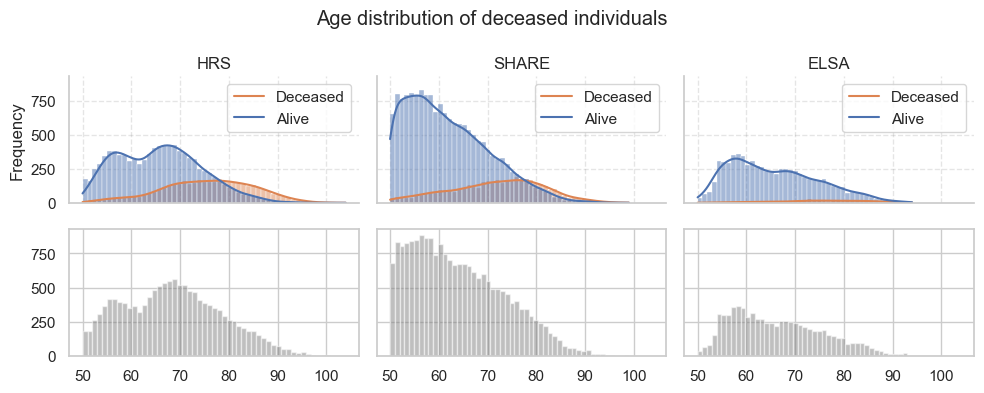

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

fig,ax = plt.subplots(2,3, figsize=(10,4),sharey=True,sharex=True)
axs = ax.flatten()
for i,dataset in enumerate(['HRS','SHARE','ELSA']):
    df = params.data_reader(dataset=dataset,source='us',bio=False)
    sns.histplot(data=df,x='age',hue='death',ax=axs[i],kde=True,alpha=0.5,bins=df['age'].nunique()+1 if dataset=='HRS' else df['age'].nunique())
    axs[i].set_title(f'{dataset}')
    axs[i].set_xlabel('Age')
    axs[i].set_ylabel('Frequency')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].grid(axis='both',color='gray', linestyle='--', linewidth=1,alpha=0.2)
    axs[i].legend(['Deceased','Alive'])
    
    axs[i+3].hist(df['age'],bins=df['age'].nunique()+1 if dataset=='HRS' else df['age'].nunique(),color='gray',alpha=0.5)
    # axs[i].grid(False)
fig.suptitle('Age distribution of deceased individuals')
fig.tight_layout()

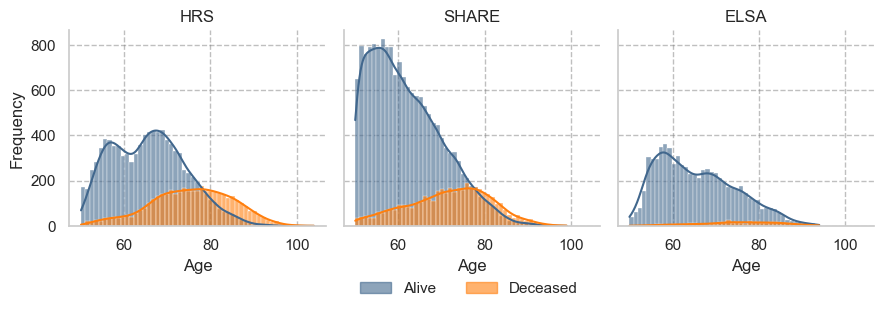

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True, sharex=True)
axs = ax.flatten()

for i, dataset in enumerate(['HRS', 'SHARE', 'ELSA']):
    # Load dataset
    df = params.data_reader(dataset=dataset, source='us', bio=False)
    
    # Plot stacked histogram
    sns.histplot(
        data=df,
        x='age',
        hue='death',
        hue_order=[1, 0],  # Ensure that the colors are consistent
        ax=axs[i],
        #multiple='stack',  # Stacked histogram
        kde=True,
        alpha=0.6,
        palette={0: colors['blue'], 1: colors['orange']},
        bins=df['age'].nunique()+1 if dataset=='HRS' else df['age'].nunique()

    )
    
    # Formatting
    axs[i].set_title(f'{dataset}')
    axs[i].set_xlabel('Age')
    axs[i].set_ylabel('Frequency')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].grid(axis='y', color='gray', linestyle='--', linewidth=1, alpha=0.5)
    axs[i].grid(axis='x', color='gray', linestyle='--', linewidth=1, alpha=0.5)
    axs[i].get_legend().remove()
alive_patch = mpatches.Patch(color=colors['blue'], label='Alive', alpha=0.6)
deceased_patch = mpatches.Patch(color=colors['orange'], label='Deceased', alpha=0.6)

# Create a single legend at the bottom
fig.legend(
    handles=[alive_patch, deceased_patch],
    loc='lower center',
    ncol=2,  # Arrange legend items horizontally
    bbox_to_anchor=(0.53, -0.06),  # Position at the bottom of the figure
    frameon=False
)

# Add a super title for all subplots
#fig.suptitle('Age Distribution by Death Status', fontsize=14)

#plt.subplots_adjust(bottom=0.1) 
fig.tight_layout()# Adjust layout to make room for legend
plt.savefig('graphs/data_description/age_distribution_with_death.pdf')

In [5]:
for dataset in ['HRS','ELSA','SHARE']:
    df=params.data_reader(dataset=dataset,source='us',bio=False)
    df = df.loc[df['death']==1,'age']
    print(dataset,"\n",df.mean(),df.median(),df.std()) 

HRS 
 75.55056455571919 76.0 9.37585853276898
ELSA 
 75.17985611510791 76.0 9.344052868948726
SHARE 
 71.74231508165225 73.0 9.58520589299974


# Risk Facotr inclusion/exclusion

In [47]:
df_all_variables = pd.DataFrame()
df_all_variables['variables'] = list(set([x for domain in params.domain_dict.keys() if domain not in ['bio','bio_adjusted','all_bio','all_bio_adjusted'] for x in params.domain_dict[domain]]))

# mark variables from each dataset 
for dataset in ['HRS','SHARE','ELSA']:
    df_all_variables[dataset] = None
    df = params.data_reader(dataset=dataset,source='us',bio=False)
    for var in params.domain_dict['all']:
        if var in df.columns:
            df_all_variables.loc[df_all_variables['variables']==var,dataset] = 1
            
# Add domain column
df_all_variables['domain'] = df_all_variables['variables']
for domain in ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']:
    domain_vars = params.domain_dict[domain]
    if domain != 'demographic':
        domain_vars = list(set(domain_vars)-set(params.domain_dict['demographic']))
    df_all_variables.loc[df_all_variables['variables'].isin(domain_vars),'domain']= domain
    
# Sort the dataframe by domain 
df_all_variables.sort_values('domain', inplace=True)
df_all_variables.reset_index(drop=True,inplace=True)
df_all_variables.fillna(0,inplace=True)



In [192]:
# Replace variables with readable names
heatmap_data = df_all_variables.set_index('variables')[['HRS', 'SHARE', 'ELSA']]
df_means = pd.DataFrame(heatmap_data).copy()
for dataset in ['HRS', 'SHARE', 'ELSA']:
    
    if dataset =='SHARE':
        df = pd.read_pickle("/Users/valler/Python/OX_Thesis/OX_thesis/data/SHARE/recoded_data_wave_1.pkl")
        df = df.loc[(df['deathY']>2005)|(df['death']==0),]
        df = df.loc[df['age'] >= 50,]
        
    elif dataset == 'ELSA':
        
        df = pd.read_csv('/Users/valler/Python/OX_Thesis/OX_thesis/Data/ELSA/recoded_data_w2.csv')
        df.loc[df['radyear']<=2004,'delete']=True
        df.drop(df.loc[df['delete']==True].index,axis=0,inplace=True)
        df.drop(columns=['delete'],inplace=True)
        df=df.dropna(thresh=int(0.8*len(df.columns)))
        df['age']=[2005-x for x in df['rabyear']]
        df.rename(columns={'male':'maleYN','white':'blackYN'},inplace=True)
        df['blackYN']=[1 if x==-1 else -1 for x in df['blackYN']]
        
    elif dataset == 'HRS':
        df = pd.read_pickle('/Users/valler/Python/OX_Thesis/OX_thesis/data/HRS/data_preprocess/Data/merge_data_not_standardise.pkl')
    

    for var in df_means.index:
        if var in df.columns:
            if df[var].nunique()==2:
               df[var] = df[var].replace(-1,0)
            df[var] = df[var].astype(float)
            df_means.loc[var, dataset] = f'mean: {df[var].mean():.2f}({df[var].std():.2f})'
        else:
            df_means.loc[var, dataset] = '-'

In [193]:
df_HRS = params.data_reader(dataset='HRS', source='us', bio=False)
df_HRS['hhidpn'] =  ["{:06d}".format(int(x)) + '{:03d}'.format(int(y)) for x, y in zip(df_HRS['hhid'], df_HRS['pn'])]
hhidpn_list  = df_HRS['hhidpn'].to_list()

df = pd.read_pickle('/Users/valler/Python/OX_Thesis/OX_thesis/data/HRS/data_preprocess/Data/merge_data_not_standardise_all.pkl')
df.rename({'MaleYN':'maleYN','BlackYN':'blackYN','HispanicYN':'hispanicYN'},axis=1,inplace=True)

df = df.loc[df['hhidpn'].isin(hhidpn_list),]
df.drop(columns=['interview_year'],inplace=True)
df=df.merge(df_HRS[['hhidpn','interview_year','age']],on='hhidpn',how='left')
df.to_pickle('/Users/valler/Python/OX_Thesis/OX_thesis/data/HRS/data_preprocess/Data/merge_data_not_standardise.pkl')

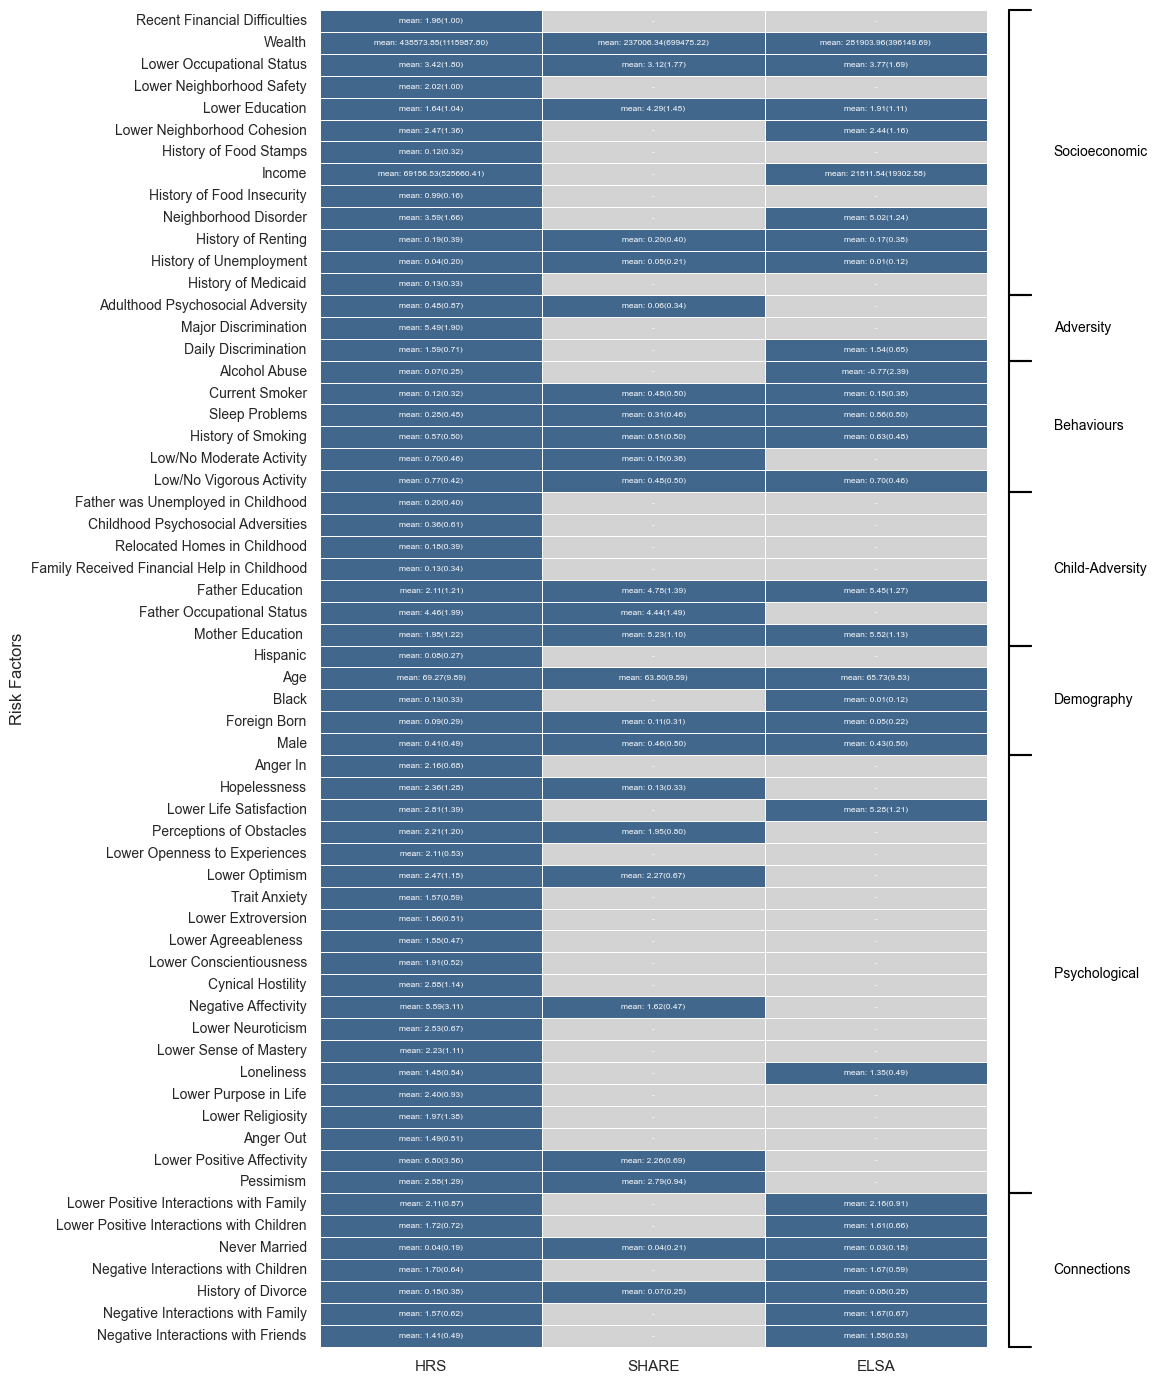

In [195]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological ',
                      'bio_adjusted':'Biomarkers',
                       'pr_f1_contribution':'F1 Score',
                       'pr_auc_contribution':'PR-AUC Score',
                      'roc_auc_contribution':'ROC-AUC Score',
                      'imv_contribution':'IMV'}

# Replace variables with readable names
heatmap_data = df_all_variables.set_index('variables')[['HRS', 'SHARE', 'ELSA']]


heatmap_data.index = heatmap_data.index.map(lambda x: params.var_dict.get(x, x))  # Replace with readable names

# Custom colormap
custom_cmap = ListedColormap([colors['grey'], colors['blue']])

# Plot heatmap
plt.figure(figsize=(12, 14))
ax = sns.heatmap(
    heatmap_data,
    annot = df_means,
    fmt="", 
    annot_kws={"size": 6, "color": "white", "ha": "center"},
    cmap=custom_cmap,  # Color scheme
    linewidths=0.5,
    cbar=False,  # Remove the color bar
)

# Adjust y-axis label size
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)  # Adjust font size for y-axis labels

# Add brackets and one label per domain
domain_groups = df_all_variables.groupby('domain')
for domain, group in domain_groups:
    start_idx = group.index[0]  # Start index of the domain
    end_idx = group.index[-1]  # End index of the domain
    
    # Add text for the domain
    ax.text(
        heatmap_data.shape[1] + 0.3,  # Position on the right of the plot
        (start_idx + end_idx + 1) / 2,  # Midpoint of the domain rows
        f'{replace_name_dict[domain]}',  # Text for the domain
        va='center', ha='left', fontsize=10, color='black'
    )
    
    # Add brackets for the domain
    ax.plot(
        [heatmap_data.shape[1] + 0.1] * 2,  # Vertical line position (right of the plot)
        [start_idx, end_idx + 1],  # Span of the domain
        color='black', linewidth=1.5, clip_on=False
    )
    ax.plot(
        [heatmap_data.shape[1] + 0.1, heatmap_data.shape[1] + 0.2],  # Horizontal line (top)
        [start_idx, start_idx],  # Top of the bracket
        color='black', linewidth=1.5, clip_on=False
    )
    ax.plot(
        [heatmap_data.shape[1] + 0.1, heatmap_data.shape[1] + 0.2],  # Horizontal line (bottom)
        [end_idx + 1, end_idx + 1],  # Bottom of the bracket
        color='black', linewidth=1.5, clip_on=False
    )

# Add labels and title
#plt.title('Variable Availability in Datasets', fontsize=12)
# plt.xlabel('Datasets')
plt.ylabel('Risk Factors')

# Add a legend below the plot
legend_labels = [
    
    mpatches.Patch(color=colors['blue'], label='Available'),
    mpatches.Patch(color=colors['grey'], label='Not Available')
]
'''plt.legend(
    handles=legend_labels,
    loc='lower center',
    bbox_to_anchor=(1.4, -0.01),
    ncol=1,
    frameon=False,
    fontsize=9
)'''

# Adjust layout
plt.tight_layout()
# Show plot
plt.savefig('graphs/data_description/variable_availability_with_datainfo.pdf')


test on the model fit with different seeds

In [1]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('reset', '-sf')


In [2]:
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner

# platform = "jupyter"
# params.confirm_cwd(platform)

model_params = params.model_params
colors = {'blue':'#62a0cb','orange':'#ff7f0e','green':'#2ca02c'}
temp = pd.read_csv(Path.cwd()/'results/sl_10seeds_ELSA.csv')
ELSA_seeds = list(temp['seed'].unique())

In [3]:

from sklearn.metrics import confusion_matrix, precision_score

def ELSA_additional_evals(true_vals, pred_probs, threshold=0.5):

    # Convert probabilities to binary predictions based on the threshold
    pred_vals = [1 if prob >= threshold else 0 for prob in pred_probs]

    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(true_vals, pred_vals).ravel()

    # Calculate metrics
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Sensitivity)
    precision = precision_score(true_vals, pred_vals, zero_division=0)  # Precision

    # Likelihood ratio (LR+): TPR / FPR
    lr = tpr / fpr if fpr > 0 else float('inf')  # Avoid division by zero

    return {'fpr': fpr, 'tpr': tpr, 'precision': precision, 'lr': lr}


In [4]:
df_elsa_in_comb = pd.DataFrame(columns = ['method','imv','roc_auc','pr_auc','efron_r2','pr_no_skill','fpr','tpr','precision','lr','seed'])
threshold = 0.5 
#ELSA_seeds = [100000,18127,171615,191715,191917,191817,191716,9171514,1416273,7151413]
for seed_ind in range(10):
    ELSA_seed = int(ELSA_seeds[seed_ind] )
    
    # block 1 ELSA 
    method = 'ELSA model'
    df = params.data_reader(dataset='ELSA',source='us',bio=False)
    #print(df.loc[0,'ZincomeT'])
    domain_name = 'elsa_all'
    elsa_model_params = params.model_params
    elsa_model_params['random_state']=ELSA_seed
    print('ELSA SEEDS',elsa_model_params['random_state'])
    elsa_model_params['domain_dict'][domain_name]= list(set(elsa_model_params['domain_dict']['all']).intersection(set(df.columns)))
    # recode a new domain dict for SHARE  based on its columns
    #print(elsa_model_params['domain_dict'][domain_name])
    model_name = 'lgb'
    elsa_model = Models.Model_fixed_test_size(data=df, model_params=elsa_model_params, domain=domain_name, model='lgb', train_subset_size=1, order=0)
    evas=metric(elsa_model)
    evas_new = ELSA_additional_evals(elsa_model.y_test, elsa_model.test_set_predict_prob, threshold=threshold)
    df_elsa_in_comb.loc[len(df_elsa_in_comb),] = [method,evas.imv,evas.auc_score,evas.pr_auc,evas.efron_rsquare,evas.pr_no_skill,evas_new['fpr'],evas_new['tpr'],evas_new['precision'],evas_new['lr'],ELSA_seed]    
    
    del df,domain_name,evas,method,evas_new,elsa_model_params,elsa_model,ELSA_seed
    

ELSA SEEDS 387803878
ELSA SEEDS 2024845086
ELSA SEEDS 2060493052
ELSA SEEDS 1179036763
ELSA SEEDS 878831439
ELSA SEEDS 4178301729
ELSA SEEDS 598841858
ELSA SEEDS 650222086
ELSA SEEDS 1371556954
ELSA SEEDS 1422354210
